In [27]:
import os
import time

import gensim
import lucem_illud
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.cluster.hierarchy
import sklearn
import sklearn.cluster
import sklearn.datasets
import sklearn.decomposition
import sklearn.feature_extraction.text
import sklearn.metrics
import sklearn.pipeline
import sklearn.preprocessing

%matplotlib inline

## Utility Functions

In [4]:
# I modified this function so that I could just get the silhouette score without
# the resulting plots. This would allow me to post more scores in my analysis
# without the clutter of LOTS of plots.
def plot_silhouette(n_clusters, vector_array, hide_plot: bool = False):
    if not hide_plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(vector_array) + (n_clusters + 1) * 10])

    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(vector_array)

    silhouette_avg = sklearn.metrics.silhouette_score(vector_array, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(
        vector_array, cluster_labels
    )

    y_lower = 10

    pca = sklearn.decomposition.PCA(n_components=n_clusters).fit(vector_array)
    reduced_data = pca.transform(vector_array)

    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        if not hide_plot:
            ax1.fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=color,
                edgecolor=color,
                alpha=0.7,
            )

            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10

    if not hide_plot:
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        colors = cmap(float(i) / n_clusters)
        ax2.scatter(
            reduced_data[:, 0],
            reduced_data[:, 1],
            marker=".",
            s=30,
            lw=0,
            alpha=0.7,
            c=colors,
        )

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        projected_centers = pca.transform(centers)
        # Draw white circles at cluster centers
        ax2.scatter(
            projected_centers[:, 0],
            projected_centers[:, 1],
            marker="o",
            c="white",
            alpha=1,
            s=200,
        )

        for i, c in enumerate(projected_centers):
            ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("PC 1")
        ax2.set_ylabel("PC 2")

        plt.suptitle(
            (
                "Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters
            ),
            fontsize=14,
            fontweight="bold",
        )

        plt.show()
    print(
        f"For n_clusters = {n_clusters}, The average silhouette_score is : {silhouette_avg:.3f}"
    )

In [5]:
def cluster_scoring(df_column, labels):
    print("Cluster scoring:")
    print(
        f"-- Homogeneity: {sklearn.metrics.homogeneity_score(df_column, labels):0.3f}"
    )
    print(
        f"-- Completeness: {sklearn.metrics.completeness_score(df_column, labels):0.3f}"
    )
    print(f"-- V-measure: {sklearn.metrics.v_measure_score(df_column, labels):0.3f}")
    print(
        f"-- Adjusted Rand Score: {sklearn.metrics.adjusted_rand_score(df_column, labels):0.3f}"
    )

In [6]:
# Drop a word if it is an empty string or the vocab word.
def drop_missing(word_list, vocab):
    return [w for w in word_list if w in vocab or not w]

## <font color="red">*Exercise 1*</font>

<font color="red">Construct cells immediately below this that construct features and 
cluster your documents using K-means and a variety of cluster numbers. Interrogate 
the cluster contents in terms of both documents and features. Identify the "optimal" 
cluster number with Silhouette analysis. Plot clusters and features after reducing 
with PCA. What does this cluster structure reveal about the organization of documents 
in your corpora?

In [7]:
# Import abortion related legislation CSV.
abortion_legislation_df = pd.read_csv("data/congress_legislation_cleaned.csv")
abortion_legislation_df[:5]

,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,api_url,text_url,raw_text,cleaned_text,cleaned_summary
0,H.R. 2907,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,hr,2907,https://api.congress.gov/v3/bill/118/hr/2907/t...,https://www.congress.gov/118/bills/hr2907/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...
1,S. 1297,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,s,1297,https://api.congress.gov/v3/bill/118/s/1297/te...,https://www.congress.gov/118/bills/s1297/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...
2,H.R. 4901,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,hr,4901,https://api.congress.gov/v3/bill/118/hr/4901/t...,https://www.congress.gov/118/bills/hr4901/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...
3,S. 2544,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,s,2544,https://api.congress.gov/v3/bill/118/s/2544/te...,https://www.congress.gov/118/bills/s2544/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...
4,H.R. 4147,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Training Act of 2023,NaN,NaN,NaN,118,hr,4147,https://api.congress.gov/v3/bill/118/hr/4147/t...,https://www.congress.gov/118/bills/hr4147/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,NaN


In [8]:
# Vectorize the cleaned legislative text.
count_vectorizer = sklearn.feature_extraction.text.CountVectorizer()
legislation_vectors = count_vectorizer.fit_transform(
    abortion_legislation_df["cleaned_text"]
)

# Get tf-idf measurements for the count vectors.
legislation_tfidf_transformer = sklearn.feature_extraction.text.TfidfTransformer().fit(
    legislation_vectors
)
legislation_tf = legislation_tfidf_transformer.transform(legislation_vectors)
print(legislation_tf.shape)
legislation_vectors

(1243, 47501)


<1243x47501 sparse matrix of type '<class 'numpy.int64'>'
	with 1379333 stored elements in Compressed Sparse Row format>

In [9]:
# Look up the index for the word "abortion".
print(
    f"Here's a sample of keys in the count vectorizer: {list(count_vectorizer.vocabulary_.keys())[:10]}"
)
# Going to see what 10 td-idf measurements for each word in the count vectorizer.
list(zip(count_vectorizer.vocabulary_.keys(), legislation_tf.data))[:10]

Here's a sample of keys in the count vectorizer: ['congressional', 'bills', '118th', 'congress', 'from', 'the', 'government', 'publishing', 'office', '2907']


[('congressional', 0.0066927330267921034),
 ('bills', 0.007110764726327887),
 ('118th', 0.007507733839139965),
 ('congress', 0.05031528442239425),
 ('from', 0.023380940294262655),
 ('the', 0.03140861880433304),
 ('government', 0.0077280169928850275),
 ('publishing', 0.007304778786360571),
 ('office', 0.009358640270209212),
 ('2907', 0.010989290534829797)]

In [10]:
# Apply the Tf-idf filter to our text and take a look at the results.
# This is being used to remove stop words and words that are entirely too
# ubiquitous to be meaningful in the text.
# I am configuring this vectorizer so that a word cannot show up in more than
# half the documents, must show up at least 3x, and the model can only have a
# maximum of 1000 features.
tfidf_vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(
    max_df=0.5, max_features=1000, min_df=3, stop_words="english", norm="l2"
)
# Train vectorizer.
al_tfidf_vectors = tfidf_vectorizer.fit_transform(
    abortion_legislation_df["cleaned_text"]
)
print(
    f"Here's a sample of keys in the tf-idf vectorizer: {list(tfidf_vectorizer.vocabulary_.keys())[:10]}"
)

Here's a sample of keys in the tf-idf vectorizer: ['ensure', 'right', 'reproductive', '2023', 'ms', 'energy', 'addition', 'judiciary', 'determined', 'consideration']


In [11]:
# In the count vectorizers list you can see 'from' and 'the', I'll verify
# that they aren't in the td-idf vectorizer.
for sw in ["from", "the"]:
    try:
        tfidf_vectorizer.vocabulary_[sw]
    except KeyError:
        print(f"'{sw}' is NOT in the tf-idf vectors.")

'from' is NOT in the tf-idf vectors.
'the' is NOT in the tf-idf vectors.


In [17]:
# We do NOT have a base set of categories, so we cannot entirely replicate
# the analysis done above. What we can do is see which amount of clusters
# give us the best silhouette average in the least amount of clusters.
# Based off of the previous silhouette analysis, we are looking for the least
# amount of clusters with the highest average silhouette score.
# Going to start with just prime numbers and focus on the range where
# the average silhouette score starts to dip.
for n_clust in [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43]:
    legislation_km = sklearn.cluster.KMeans(n_clusters=n_clust, init="k-means++")
    legislation_km.fit(al_tfidf_vectors.toarray())
    plot_silhouette(n_clust, al_tfidf_vectors.toarray(), True)

For n_clusters = 2, The average silhouette_score is : 0.056
For n_clusters = 3, The average silhouette_score is : 0.073
For n_clusters = 5, The average silhouette_score is : 0.103
For n_clusters = 7, The average silhouette_score is : 0.122
For n_clusters = 11, The average silhouette_score is : 0.140
For n_clusters = 13, The average silhouette_score is : 0.133
For n_clusters = 17, The average silhouette_score is : 0.153
For n_clusters = 19, The average silhouette_score is : 0.166
For n_clusters = 23, The average silhouette_score is : 0.147
For n_clusters = 29, The average silhouette_score is : 0.163
For n_clusters = 31, The average silhouette_score is : 0.172
For n_clusters = 37, The average silhouette_score is : 0.193
For n_clusters = 41, The average silhouette_score is : 0.192
For n_clusters = 43, The average silhouette_score is : 0.193


In [18]:
# It looks like the highest number we are getting with the lowest amount of
# clusters is between 31 and 43. I'll use that heuristic and use the range of
# 30 to 43 to find teh best amount of clusters.
for n_clust in range(30, 44):
    legislation_km = sklearn.cluster.KMeans(n_clusters=n_clust, init="k-means++")
    legislation_km.fit(al_tfidf_vectors.toarray())
    plot_silhouette(n_clust, al_tfidf_vectors.toarray(), True)

For n_clusters = 30, The average silhouette_score is : 0.195
For n_clusters = 31, The average silhouette_score is : 0.172
For n_clusters = 32, The average silhouette_score is : 0.204
For n_clusters = 33, The average silhouette_score is : 0.191
For n_clusters = 34, The average silhouette_score is : 0.179
For n_clusters = 35, The average silhouette_score is : 0.187
For n_clusters = 36, The average silhouette_score is : 0.190
For n_clusters = 37, The average silhouette_score is : 0.193
For n_clusters = 38, The average silhouette_score is : 0.219
For n_clusters = 39, The average silhouette_score is : 0.208
For n_clusters = 40, The average silhouette_score is : 0.199
For n_clusters = 41, The average silhouette_score is : 0.192
For n_clusters = 42, The average silhouette_score is : 0.199
For n_clusters = 43, The average silhouette_score is : 0.193


/var/folders/67/q6s_d9w52v540n1lkmrr2k740000gn/T/ipykernel_5528/1960152383.py:61: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax2.scatter(


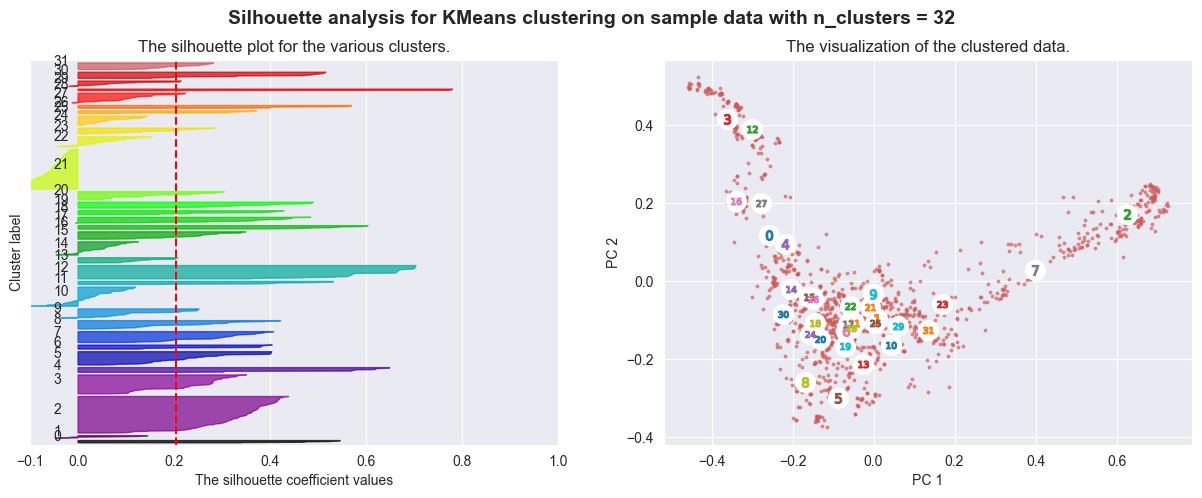

For n_clusters = 32, The average silhouette_score is : 0.204


In [62]:
# Based on the output of the above cell, 32 appears to be the optimal
# amount of clusters as it reaches the second-highest average silhouette score
# of our samples and has the fewest amount of clusters.
optimal_clusters = 32
optimal_legislation_km = sklearn.cluster.KMeans(
    n_clusters=optimal_clusters, init="k-means++"
)
optimal_legislation_km.fit(al_tfidf_vectors.toarray())
plot_silhouette(optimal_clusters, al_tfidf_vectors.toarray())

In [13]:
# Adding labels to corpus DataFrame.
abortion_legislation_df["kmeans_predictions"] = optimal_legislation_km.labels_
abortion_legislation_df[:10]

,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,api_url,text_url,raw_text,cleaned_text,cleaned_summary,kmeans_predictions
0,H.R. 2907,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,hr,2907,https://api.congress.gov/v3/bill/118/hr/2907/t...,https://www.congress.gov/118/bills/hr2907/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29
1,S. 1297,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,s,1297,https://api.congress.gov/v3/bill/118/s/1297/te...,https://www.congress.gov/118/bills/s1297/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29
2,H.R. 4901,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,hr,4901,https://api.congress.gov/v3/bill/118/hr/4901/t...,https://www.congress.gov/118/bills/hr4901/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7
3,S. 2544,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,s,2544,https://api.congress.gov/v3/bill/118/s/2544/te...,https://www.congress.gov/118/bills/s2544/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7
4,H.R. 4147,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Training Act of 2023,NaN,NaN,NaN,118,hr,4147,https://api.congress.gov/v3/bill/118/hr/4147/t...,https://www.congress.gov/118/bills/hr4147/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,NaN,0
5,S. 2024,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Reproductive Health Care Training Act of 2023,NaN,NaN,NaN,118,s,2024,https://api.congress.gov/v3/bill/118/s/2024/te...,https://www.congress.gov/118/bills/s2024/BILLS...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,NaN,0
6,H.R. 1723,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Abortion is Health Care Everywhere Act of 2023,NaN,NaN,<p><b>Abortion is Health Care Everywhere Act ...,118,hr,1723,https://api.congress.gov/v3/bill/118/hr/1723/t...,https://www.congress.gov/118/bills/hr1723/BILL...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Abortion is Health Care Everywhere Act of 2023...,1
7,S. 929,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Abortion is Health Care Everywhere Act of 2023,NaN,NaN,<p><b>Abortion is Health Care Everywhere Act ...,118,s,929,https://api.congress.gov/v3/bill/118/s/929/tex...,https://www.congress.gov/118/bills/s929/BILLS-...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Abortion is Health Care Everywhere Act of 2023...,7
8,H.R. 73,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),No Pro-Abortion Task Force Act,NaN,NaN,<p><strong>No Pro-Abortion Task Force Act</st...,118,hr,73,https://api.congress.gov/v3/bill/118/hr/73/tex...,https://www.congress.gov/118/bills/hr73/BILLS-...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bill

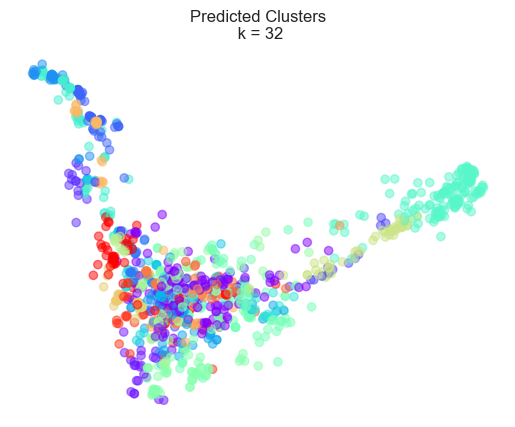

In [14]:
# Plotting using PCA reduction.
legislation_pca = sklearn.decomposition.PCA(n_components=optimal_clusters).fit(
    al_tfidf_vectors.toarray()
)
legislation_pca_data = legislation_pca.transform(al_tfidf_vectors.toarray())

colors = list(plt.cm.rainbow(np.linspace(0, 1, optimal_clusters)))
colors_p = [colors[label] for label in optimal_legislation_km.labels_]
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(
    legislation_pca_data[:, 0], legislation_pca_data[:, 1], color=colors_p, alpha=0.5
)
plt.xticks(())
plt.yticks(())
plt.title(f"Predicted Clusters\n k = {optimal_clusters}")
plt.show()

The PCA reduction gives a little more insight into why things were clustered
as they were. The reduction diminishes some of the noise in the previous plots
and makes the density of points more easily viewable since they are now orthogonal
to where they were before.

## <font color="red">*Exercise 2*</font>

<font color="red">Construct cells immediately below this that hierarchically cluster 
your documents using two approaches, and visualize them with a tree. Interrogate the 
recursive cluster contents in terms of both documents and closenesses. What does this
nested cluster structure reveal about the organization of documents in your sampled 
corpora? Moreover, if they do worse than kmeans (as above), why do you think this is 
the case (hint: using metrics if you have ground truth or silhouette if you do not)?

<font color="red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they 
change the arrangement of clusters?

In [67]:
# Using the al_tfidf_vectors vectors.
print(
    f"Here's a sample of keys in the tf-idf vectorizer: {list(tfidf_vectorizer.vocabulary_.keys())[:10]}"
)
al_tfidf_vectors

Here's a sample of keys in the tf-idf vectorizer: ['ensure', 'right', 'reproductive', '2023', 'ms', 'energy', 'addition', 'judiciary', 'determined', 'consideration']


<1243x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 331518 stored elements in Compressed Sparse Row format>

In [68]:
al_tfidf_vectors.todense()
al_cooc_mat = al_tfidf_vectors * al_tfidf_vectors.T
al_cooc_mat.setdiag(0)
al_linkage_matrix = scipy.cluster.hierarchy.ward(al_cooc_mat.toarray())
al_hierarchical_fclusters_full = scipy.cluster.hierarchy.fcluster(
    al_linkage_matrix, optimal_clusters, "maxclust"
)
abortion_legislation_df["ward_clusters"] = al_hierarchical_fclusters_full
plot_silhouette(optimal_clusters, al_tfidf_vectors.toarray(), True)
abortion_legislation_df.head(3)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:833: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


For n_clusters = 32, The average silhouette_score is : 0.204


,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,...,raw_text,cleaned_text,cleaned_summary,kmeans_predictions,fcluster_predictions,tokenized_text,normalized_tokens,reduced_tokens,complete_clusters,ward_clusters
0,H.R. 2907,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,hr,2907,...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[time, enforcement, or, protective, considerat...","[publishing, time, enforcement, protective, co...","[enforcement, consideration, specific, affecte...",30,12
1,S. 1297,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,s,1297,...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[Murphy, time, Hirono, enforcement, Welch, or,...","[publishing, time, van, enforcement, mrs, prot...","[enforcement, specific, affected, defined, sin...",30,12
2,H.R. 4901,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,hr,4901,...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, g, Community, throughout, partici...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration...",30,12


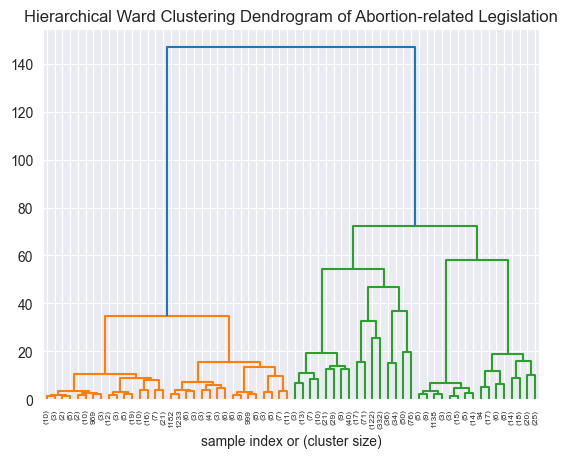

In [69]:
plt.title("Hierarchical Ward Clustering Dendrogram of Abortion-related Legislation")
plt.xlabel("sample index or (cluster size)")
ax = scipy.cluster.hierarchy.dendrogram(al_linkage_matrix, p=5, truncate_mode="level")

In [70]:
al_complete_linkage_matrix = scipy.cluster.hierarchy.complete(al_cooc_mat.toarray())
al_hierarchical_fclusters_com_full = scipy.cluster.hierarchy.fcluster(
    al_complete_linkage_matrix, optimal_clusters, "maxclust"
)
abortion_legislation_df["complete_clusters"] = al_hierarchical_fclusters_com_full
plot_silhouette(optimal_clusters, al_tfidf_vectors.toarray(), True)
abortion_legislation_df.head(3)

/Users/michaelp/Documents/GitHub/computational-content-analysis/.venv/lib/python3.11/site-packages/scipy/cluster/hierarchy.py:363: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='complete', metric='euclidean')


For n_clusters = 32, The average silhouette_score is : 0.204


,legislation number,url,congress,title,date proposed,amends amendment,latest summary,congress_num,bill_type,bill_num,...,raw_text,cleaned_text,cleaned_summary,kmeans_predictions,fcluster_predictions,tokenized_text,normalized_tokens,reduced_tokens,complete_clusters,ward_clusters
0,H.R. 2907,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,hr,2907,...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[time, enforcement, or, protective, considerat...","[publishing, time, enforcement, protective, co...","[enforcement, consideration, specific, affecte...",30,12
1,S. 1297,https://www.congress.gov/bill/118th-congress/s...,118th Congress (2023-2024),Let Doctors Provide Reproductive Health Care Act,NaN,NaN,<p><strong>Let Doctors Provide Reproductive H...,118,s,1297,...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Let Doctors Provide Reproductive Health Care A...,29,2,"[Murphy, time, Hirono, enforcement, Welch, or,...","[publishing, time, van, enforcement, mrs, prot...","[enforcement, specific, affected, defined, sin...",30,12
2,H.R. 4901,https://www.congress.gov/bill/118th-congress/h...,118th Congress (2023-2024),Reproductive Health Care Accessibility Act,NaN,NaN,<p><strong>Reproductive Health Care Accessibi...,118,hr,4901,...,\n[Congressional Bills 118th Congress]\n[From ...,Congressional Bills 118th Congress From the U....,Reproductive Health Care Accessibility Act Thi...,7,2,"[experience, g, Community, throughout, partici...","[publishing, experience, g, participating, tim...","[participating, tribes, centers, consideration...",30,12


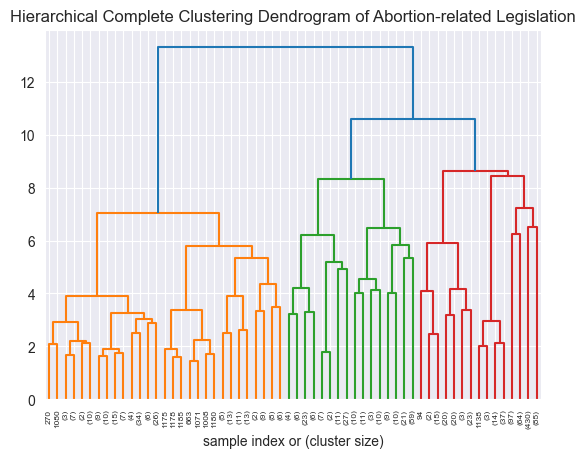

In [72]:
plt.title("Hierarchical Complete Clustering Dendrogram of Abortion-related Legislation")
plt.xlabel("sample index or (cluster size)")
ax = scipy.cluster.hierarchy.dendrogram(
    al_complete_linkage_matrix, p=5, truncate_mode="level"
)

Based on the silhouette scores of the fcluster and complete methods, the clustering
is as effective using k-means as it is a hierarchical model. The k-means silhouette
score was .204, which is the same for BOTH of the hierarchical methods. It was fairly
unexpected, honestly, but it feels intuitive that if we are at the 'optimal' amount
of clusters that the silhouette scores would be similar. All scores being somewhat
near 0, means that there is some overlap between clusters, which feels right considering
there are only a handful of ways to present legislation any given topic.

## <font color="red">*Exercise 3*</font>

<font color="red">Construct cells immediately below this that topic model 
documents related to your anticipated final project. Interrogate and visually 
plot (e.g., as a bar graph?) the topic-word loadings and the document-topic 
loadings. What does this topic structure reveal about the distribution of 
contents across your documents? Systematically vary the $\alpha$, $\eta$, and 
topic number of the model for your text and describe in detail whether and 
how these changes led to distinctive outcomes, visible to you as analyst.  

<font color="red">**Stretch**: Cluster your documents, but instead of using 
words alone, use their topic loadings as an additional set of features. Do 
these topic loadings increase the apparent semantic coherence of your clusters?</font>

In [30]:
# I have to break up the lines into segments because I'll get the following error:
# ValueError: [E088] Text of length 2653606 exceeds maximum of 1500000.s
normalized_texts = 0
tokenized_texts = 0
num_rows = abortion_legislation_df.shape[0]


def split_list(split_text):
    # Split list into chunks of 500 words
    step = 500
    text_lists = []
    for i in range(0, len(split_text), step):
        x = i
        text_lists.append(split_text[x : x + step])

    return text_lists


def tokenize_iter(text):
    start_time = time.time()
    text_lists = split_list(text.split(" "))
    res_set = set()
    for tl in text_lists:
        res_set.update(lucem_illud.word_tokenize(tl))

    global tokenized_texts
    tokenized_texts += 1
    global num_rows
    print(f"Tokenization took {round(time.time() - start_time, 2)} seconds.")
    print(f"{tokenized_texts} of {num_rows} texts tokenized.")
    return list(res_set)


def normalize_tokens(text_list):
    start_time = time.time()
    text_lists = split_list(text_list)
    res_set = set()
    for tl in text_lists:
        res_set.update(lucem_illud.normalizeTokens(tl))

    global normalized_texts
    normalized_texts += 1
    global num_rows
    print(f"Normalization took {round(time.time() - start_time, 2)} seconds.")
    print(f"{normalized_texts} of {num_rows} texts normalized.")
    return list(res_set)

In [32]:
# Since the tokenization process takes so much computational power/time, I put it
# in a feather file to avoid the time when re-running this analysis.
legislation_feather_path = "data/tokenized_congress_legislation.feather"
if os.path.isfile(legislation_feather_path):
    abortion_legislation_df = pd.read_feather(legislation_feather_path)
else:
    # WARNING: This step takes about 25 minutes, so don't run it unless you need to.
    abortion_legislation_df["tokenized_text"] = abortion_legislation_df[
        "cleaned_text"
    ].apply(tokenize_iter)
    abortion_legislation_df["normalized_tokens"] = abortion_legislation_df[
        "tokenized_text"
    ].apply(normalize_tokens)
    abortion_legislation_df["reduced_tokens"] = abortion_legislation_df[
        "normalized_tokens"
    ].apply(lambda x: drop_missing(x, tfidf_vectorizer.vocabulary_.keys()))
    abortion_legislation_dictionary = gensim.corpora.Dictionary(
        abortion_legislation_df["reduced_tokens"]
    )
    abortion_legislation_df.to_feather(legislation_feather_path)

In [33]:
abortion_legislation_dictionary = gensim.corpora.Dictionary(
    abortion_legislation_df["reduced_tokens"]
)

In [34]:
corpus = [
    abortion_legislation_dictionary.doc2bow(text)
    for text in abortion_legislation_df["reduced_tokens"]
]

In [35]:
gensim.corpora.MmCorpus.serialize("abortion_legislation.mm", corpus)
abortion_legislation_mm = gensim.corpora.MmCorpus("abortion_legislation.mm")

In [36]:
abortion_legislation_lda = gensim.models.ldamodel.LdaModel(
    corpus=abortion_legislation_mm,
    id2word=abortion_legislation_dictionary,
    num_topics=10,
    alpha="auto",
    eta="auto",
)

In [37]:
al_lda_df = pd.DataFrame(
    {
        "name": abortion_legislation_df["legislation number"],
        "topics": [
            abortion_legislation_lda[abortion_legislation_dictionary.doc2bow(rt)]
            for rt in abortion_legislation_df["reduced_tokens"]
        ],
    }
)

In [38]:
# Dict to temporally hold the probabilities
topics_prob_dict = {
    i: [0] * len(al_lda_df) for i in range(abortion_legislation_lda.num_topics)
}

# Load them into the dict
for index, topicTuples in enumerate(al_lda_df["topics"]):
    for topicNum, prob in topicTuples:
        topics_prob_dict[topicNum][index] = prob

# Update the DataFrame
for topicNum in range(abortion_legislation_lda.num_topics):
    al_lda_df["topic_{}".format(topicNum)] = topics_prob_dict[topicNum]

al_lda_df[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
1,S. 1297,"[(2, 0.059219416), (3, 0.43155974), (7, 0.0356...",0.000000,0.000000,0.059219,0.431560,0.000000,0.000000,0.000000,0.035689,0.000000,0.467674
101,H.R. 371,"[(7, 0.7725398), (9, 0.20402075)]",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.772540,0.000000,0.204021
201,S. 137,"[(3, 0.228105), (6, 0.73659885)]",0.000000,0.000000,0.000000,0.228105,0.000000,0.000000,0.736599,0.000000,0.000000,0.000000
301,S. 707,"[(0, 0.082279816), (7, 0.90610623)]",0.082280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.906106,0.000000,0.000000
401,H.R. 1430,"[(0, 0.87616247), (3, 0.107221715)]",0.876162,0.000000,0.000000,0.107222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
501,S. 764,"[(0, 0.40691155), (3, 0.05484349), (4, 0.04908...",0.406912,0.000000,0.000000,0.054843,0.049083,0.000000,0.089992,0.000000,0.150484,0.245101
601,H.R. 361,"[(3, 0.77202016), (7, 0.20889689)]",0.000000,0.000000,0.000000,0.772020,0.000000,0.000000,0.000000,0.208897,0.000000,0.000000
701,H.R. 3081,"[(0, 0.047239196), (1, 0.069496185), (2, 0.179...",0.047239,0.069496,0.179959,0.051598,0.182421,0.066934,0.035483,0.022105,0.295537,0.049227
801,S. 707,"[(0, 0.34270543), (4, 0.102289975), (6, 0.1150...",0.342705,0.000000,0.000000,0.000000,0.102290,0.000000,0.115058,0.062808,0.000000,0.371914
901,S. 487,"[(0, 0.024591373), (4, 0.12555778), (5, 0.0678...",0.024591,0.000000,0.000000,0.000000,0.125558,0.067888,0.055078,0.058080,0.000000,0.657895


In [39]:
# Visualizing the first 30 documents
num_visualized_docs = 30
al_lda_dfv = al_lda_df[:num_visualized_docs][["topic_%d" % x for x in range(10)]]
al_lda_dfv_vis_n = al_lda_df[:num_visualized_docs][["name"]]
al_lda_dfv_vis = al_lda_dfv.values
al_lda_dfv_vis_names = al_lda_dfv_vis_n.values
al_lda_dfv

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.000000,0.000000,0.039383,0.393702,0.000000,0.000000,0.000000,0.130145,0.000000,0.431084
1,0.000000,0.000000,0.059219,0.431560,0.000000,0.000000,0.000000,0.035689,0.000000,0.467674
2,0.172611,0.083984,0.000000,0.161099,0.000000,0.027313,0.060551,0.277708,0.000000,0.212392
3,0.249012,0.077094,0.000000,0.196394,0.000000,0.013315,0.082950,0.175166,0.000000,0.204441
4,0.182359,0.137591,0.000000,0.106087,0.000000,0.000000,0.188304,0.000000,0.000000,0.371524
5,0.175073,0.127384,0.000000,0.011569,0.000000,0.000000,0.086753,0.000000,0.000000,0.592604
6,0.669050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.318655,0.000000,0.000000
7,0.519476,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.468229,0.000000,0.000000
8,0.017629,0.015153,0.015902,0.017626,0.014942,0.015550,0.015395,0.856581,0.014262,0.016961
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.051351,0.000000,0.424044,0.000000,0.517165


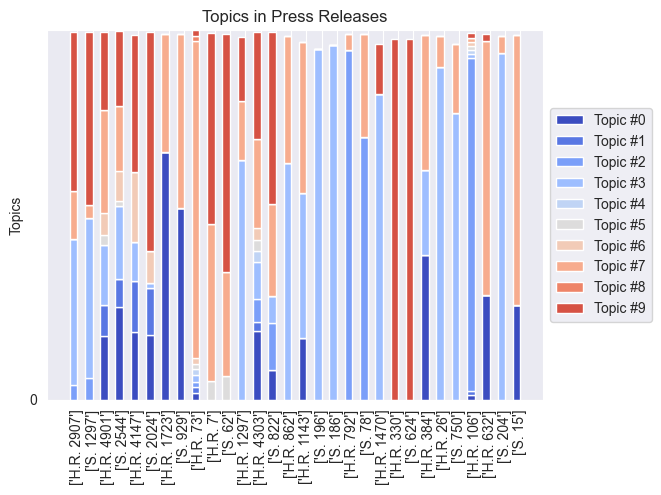

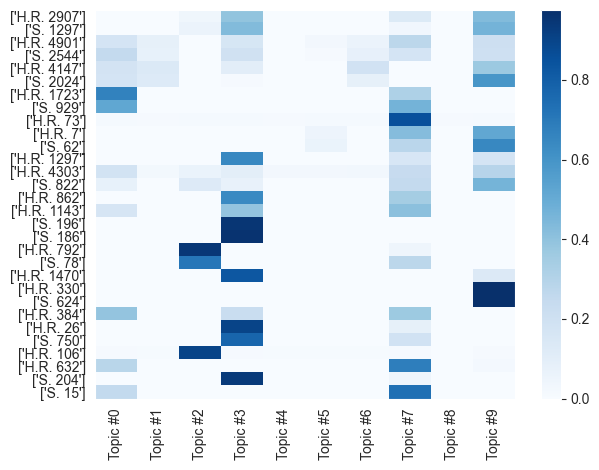

In [73]:
# Visualizing the topics in `num_visualized_docs` of documents via stacked bar chart.
ind = np.arange(num_visualized_docs)
K = abortion_legislation_lda.num_topics  # N documents, K topics
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(num_visualized_docs)

for k in range(K):
    color = plt.cm.coolwarm(k / K, 1)
    if k == 0:
        p = plt.bar(ind, al_lda_dfv_vis[:, k], width, color=color)
    else:
        p = plt.bar(
            ind, al_lda_dfv_vis[:, k], width, bottom=height_cumulative, color=color
        )
    height_cumulative += al_lda_dfv_vis[:, k]
    plots.append(p)


plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel("Topics")

plt.title("Topics in Abortion-related Legislation")
plt.xticks(ind + width / 2, al_lda_dfv_vis_names, rotation="vertical")

plt.yticks(np.arange(0, 1, 10))
topic_labels = [f"Topic #{k}" for k in range(K)]
plt.legend(
    [p[0] for p in plots],
    topic_labels,
    loc="center left",
    frameon=True,
    bbox_to_anchor=(1, 0.5),
)

plt.show()

# Visualizing the topics in `num_visualized_docs` of documents via heatmap.
plt.pcolor(al_lda_dfv_vis, norm=None, cmap="Blues")
plt.yticks(np.arange(al_lda_dfv_vis.shape[0]) + 0.5, al_lda_dfv_vis_names)
plt.xticks(np.arange(al_lda_dfv_vis.shape[1]) + 0.5, topic_labels)

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap="Blues")
plt.tight_layout()  # fixes margins
plt.show()

Using the standard values of alpha and eta, you can see the that there is
a good amount of topic crossover between documents. A good example of this,
is H.R. 2907 which has a good concentration of topic 3 and 9. The same can
be said for S. 929, which has crossover between topic 7 and 0.

### Experimenting with $\alpha$, $\eta$

$\alpha$ - controls the prior distribution over topic weights in each document; the larger the 
value, the more weight is spread across each topic; the lower the value, the more it is concentrated
on a single topic
$\eta$ - controls the prior distribution over word weights in each topic; the larger the value,
the more the weight on words is distributed throughout the whole list; the lower the value,
the more weights are only placed on the top words

In [80]:
def lda_visualization(alpha="auto", eta="auto"):
    lda = gensim.models.ldamodel.LdaModel(
        corpus=abortion_legislation_mm,
        id2word=abortion_legislation_dictionary,
        num_topics=10,
        alpha=alpha,
        eta=eta,
    )

    lda_df = pd.DataFrame(
        {
            "name": abortion_legislation_df["legislation number"],
            "topics": [
                lda[abortion_legislation_dictionary.doc2bow(rt)]
                for rt in abortion_legislation_df["reduced_tokens"]
            ],
        }
    )

    # Dict to temporally hold the probabilities
    lda_topics_prob_dict = {i: [0] * len(al_lda_df) for i in range(lda.num_topics)}

    # Load them into the dict
    for idx, topic_tuples in enumerate(lda_df["topics"]):
        for topic_num, lda_prob in topic_tuples:
            lda_topics_prob_dict[topic_num][idx] = lda_prob

    # Update the DataFrame
    for topic_num in range(lda.num_topics):
        lda_df["topic_{}".format(topic_num)] = lda_topics_prob_dict[topic_num]

    # Visualizing the first 30 documents
    lda_dfv = lda_df[:num_visualized_docs][["topic_%d" % x for x in range(10)]]
    lda_dfv_vis_n = lda_df[:num_visualized_docs][["name"]]
    lda_dfv_vis = lda_dfv.values
    lda_dfv_vis_names = lda_dfv_vis_n.values

    # Visualizing the topics in `num_visualized_docs` of documents via stacked bar chart.
    ind = np.arange(num_visualized_docs)
    K = lda.num_topics  # N documents, K topics
    width = 0.5  # the width of the bars
    plots = []
    height_cumulative = np.zeros(num_visualized_docs)

    for k in range(K):
        color = plt.cm.coolwarm(k / K, 1)
        if k == 0:
            p = plt.bar(ind, lda_dfv_vis[:, k], width, color=color)
        else:
            p = plt.bar(
                ind, lda_dfv_vis[:, k], width, bottom=height_cumulative, color=color
            )
        height_cumulative += lda_dfv_vis[:, k]
        plots.append(p)

    plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
    plt.ylabel("Topics")

    plt.title("Topics in Abortion-related Legislation")
    plt.xticks(ind + width / 2, lda_dfv_vis_names, rotation="vertical")

    plt.yticks(np.arange(0, 1, 10))
    lda_topic_labels = [f"Topic #{k}" for k in range(K)]
    plt.legend(
        [p[0] for p in plots],
        lda_topic_labels,
        loc="center left",
        frameon=True,
        bbox_to_anchor=(1, 0.5),
    )

    plt.show()

    # Visualizing the topics in `num_visualized_docs` of documents via heatmap.
    plt.pcolor(lda_dfv_vis, norm=None, cmap="Blues")
    plt.yticks(np.arange(lda_dfv_vis.shape[0]) + 0.5, lda_dfv_vis_names)
    plt.xticks(np.arange(lda_dfv_vis.shape[1]) + 0.5, lda_topic_labels)

    # flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
    plt.gca().invert_yaxis()

    # rotate the ticks on the x-axis
    plt.xticks(rotation=90)

    # add a legend
    plt.colorbar(cmap="Blues")
    plt.tight_layout()  # fixes margins
    plt.show()

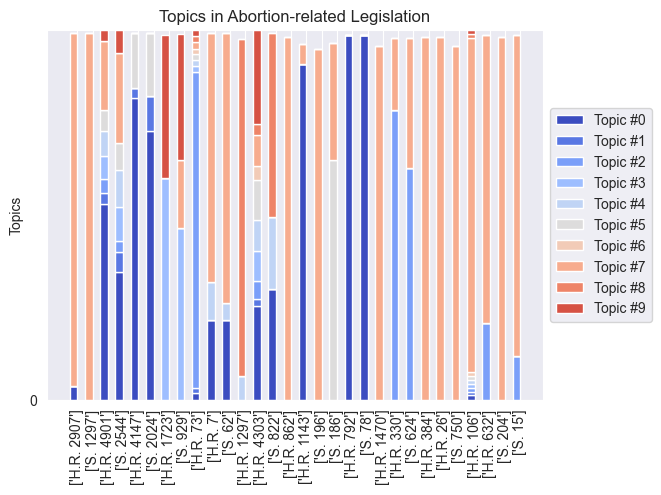

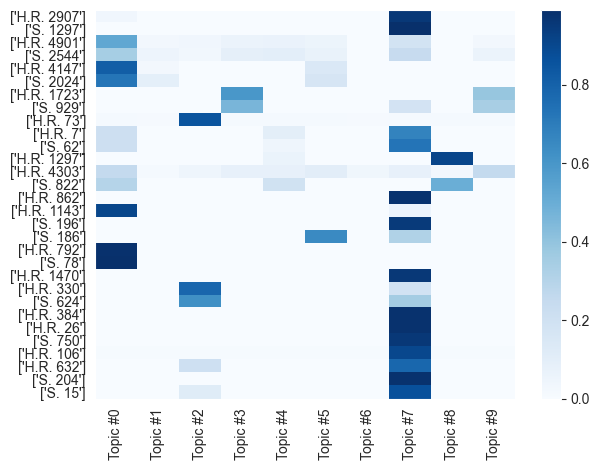

In [81]:
# Using an auto alpha and low eta
lda_visualization(eta=0.001)

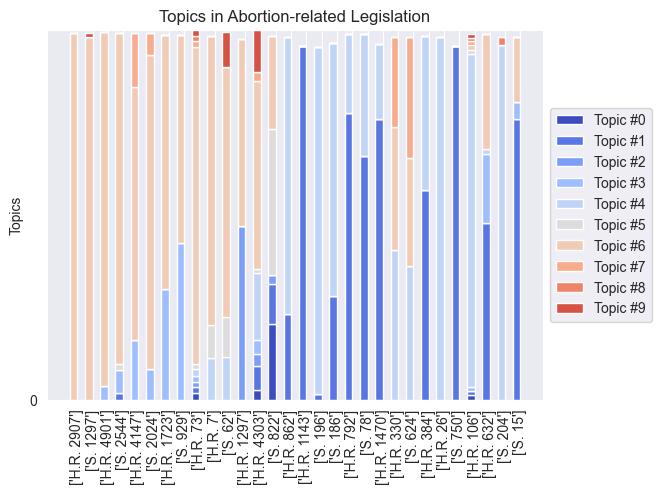

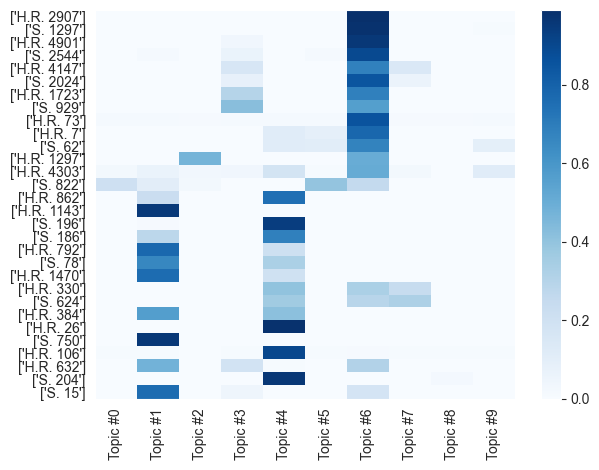

In [82]:
# Using an auto alpha and high eta
lda_visualization(eta=10)

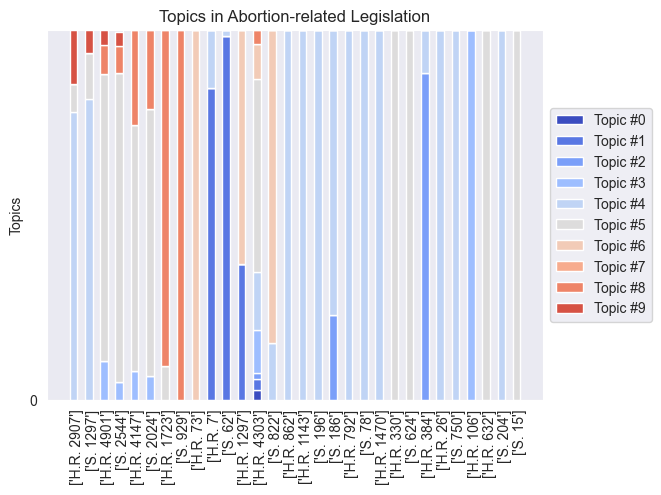

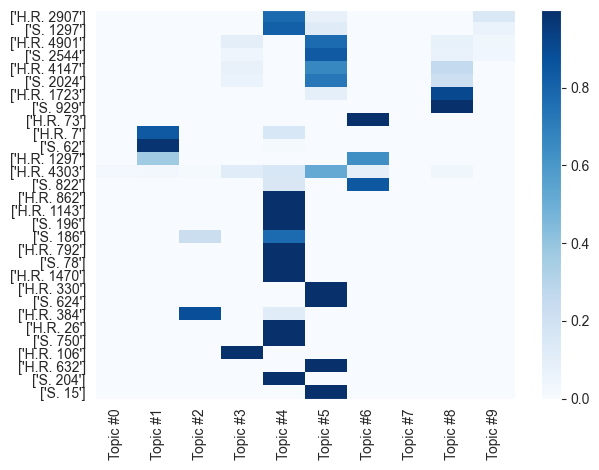

In [83]:
# Using an low alpha and auto eta
lda_visualization(0.001)

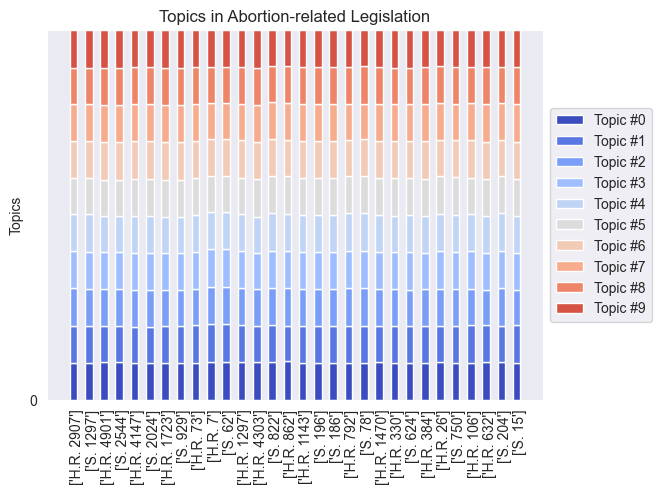

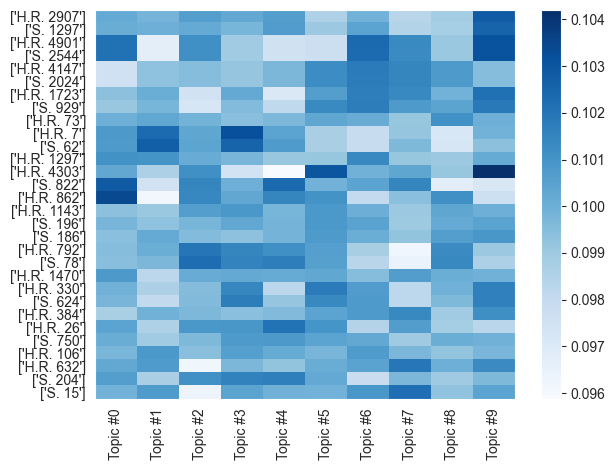

In [84]:
# Using an high alpha and auto eta
lda_visualization(10)

I found the trials to be quite illustrative of the alpha and eta manipulation.
Between the two eta trials, you can see that the concentration of topics between
documents is more dispersed with the low eta and much more concentrated in the
first couple topics with the high eta. With the low alpha value, you can see
the topics are far more concentrated with far less spread between topics and
documents. With the high alpha value you can see that every topic touches every
document, but at far less intensity (a ceiling of 1.0 for low alpha and 0.104
for high alpha).

## <font color="red">*Exercise 4*</font>

<font color="red">Construct cells immediately below this that use dynamic topic 
models on datasets relevant to your final project. You can also extend the 
analysis of the COHA or Soap datasets, if relevant to the comparison of data 
for your projects. (You could possibly use coha_genres dictionary to conduct 
analysis on topic evolution for a particular genre? What themes do you see 
evolving throughout these corpora?)

In [59]:
legislation_text = lucem_illud.loadDavies("data/congress_legislation_cleaned.csv")

NotADirectoryError: [Errno 20] Not a directory: 'data/congress_legislation_cleaned.csv/'